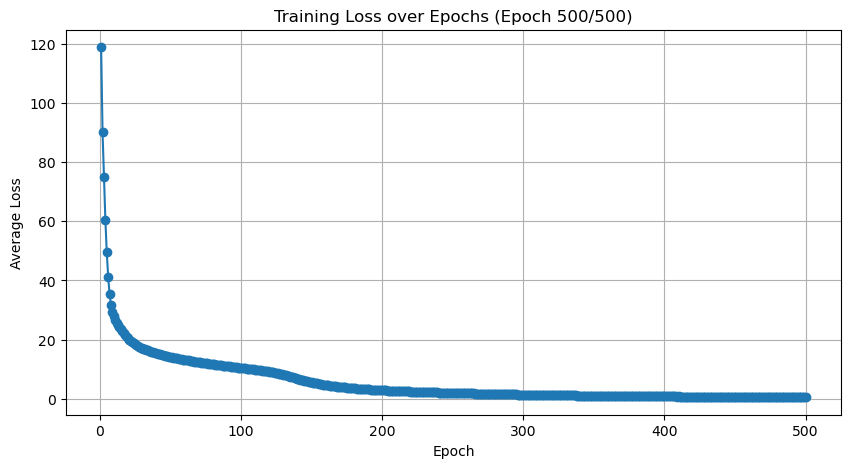

Training finished.

Predicting scores for normal and abnormal data...

Plotting score distributions...


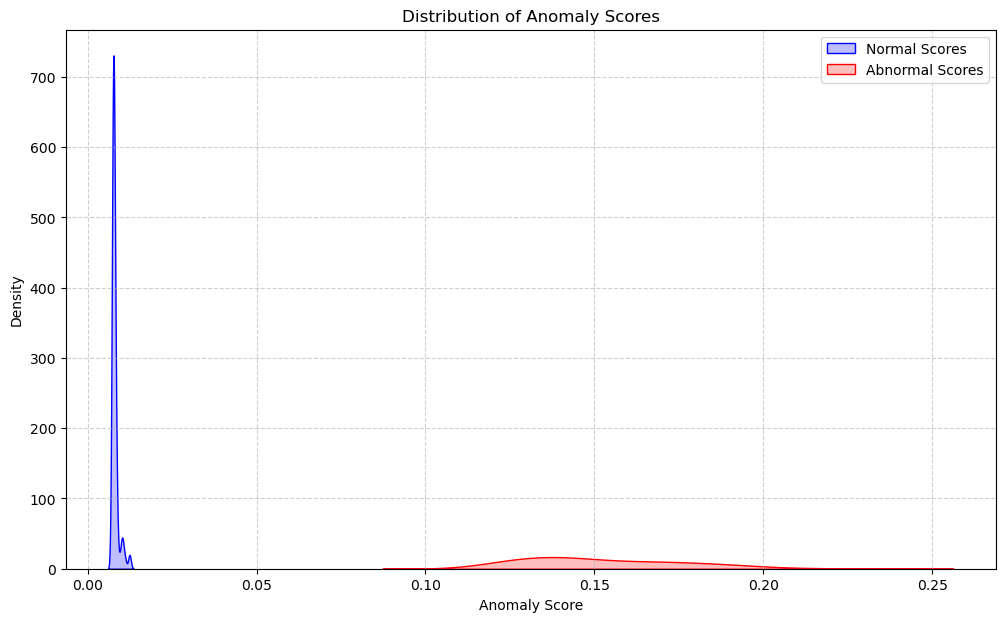

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat
from IPython.display import display, clear_output
import math

import warnings
warnings.filterwarnings("ignore")
# ======================================================================
# 1. torch.nn.Module for DCDecoder Model (Following the paper)
# ======================================================================

class RevIN(nn.Module):
    """
    [cite_start]Reversible Instance Normalization, as mentioned in the paper[cite: 243, 764].
    This normalizes each time series channel independently.
    """
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self.affine_weight = nn.Parameter(torch.ones(self.num_features))
            self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError()
        return x

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

class DataEmbedding(nn.Module):
    """
    CORRECTED DataEmbedding.
    The positional embedding now correctly uses seq_len for its shape.
    """
    def __init__(self, c_in, d_model, seq_len, dropout=0.1): # <--- FIX: Added seq_len
        super(DataEmbedding, self).__init__()
        self.value_embedding = nn.Linear(c_in, d_model)
        # <--- FIX: Use seq_len for the positional embedding's length dimension
        self.position_embedding = nn.Parameter(torch.randn(1, seq_len, d_model))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # x shape: (B, L, C), where L is the sequence length
        # The addition now works because value_embedding output is (B, L, d_model)
        # and position_embedding is (1, L, d_model), which is broadcastable.
        x = self.value_embedding(x) + self.position_embedding
        return self.dropout(x)

class DACStructure(nn.Module):
    """
    [cite_start]Dual Attention Contrastive Structure, as described in Algorithm 2 and Section 3.2.1[cite: 266].
    This module computes both patch-wise and in-patch attention representations.
    """
    def __init__(self, win_size, patch_size, d_model, n_heads, d_ff, dropout):
        super(DACStructure, self).__init__()
        self.patch_size = patch_size
        self.win_size = win_size
        self.d_model = d_model
        self.n_heads = n_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x_patch_wise, x_in_patch, patch_size_val):
        B_pw, N, _ = x_patch_wise.shape
        B_ip, P, _ = x_in_patch.shape
        
        q_pw, k_pw, v_pw = self.W_q(x_patch_wise), self.W_k(x_patch_wise), self.W_v(x_patch_wise)
        q_ip, k_ip, v_ip = self.W_q(x_in_patch), self.W_k(x_in_patch), self.W_v(x_in_patch)
        
        q_pw = q_pw.view(B_pw, N, self.n_heads, -1).transpose(1, 2)
        k_pw = k_pw.view(B_pw, N, self.n_heads, -1).transpose(1, 2)
        v_pw = v_pw.view(B_pw, N, self.n_heads, -1).transpose(1, 2)
        q_ip = q_ip.view(B_ip, P, self.n_heads, -1).transpose(1, 2)
        k_ip = k_ip.view(B_ip, P, self.n_heads, -1).transpose(1, 2)
        v_ip = v_ip.view(B_ip, P, self.n_heads, -1).transpose(1, 2)

        attn_scores_pw = torch.matmul(q_pw, k_pw.transpose(-2, -1)) / math.sqrt(self.d_model // self.n_heads)
        attn_pw = torch.softmax(attn_scores_pw, dim=-1)
        out_pw = torch.matmul(self.dropout(attn_pw), v_pw).transpose(1, 2).contiguous().view(B_pw, N, -1)
        out_pw = self.W_o(out_pw)

        attn_scores_ip = torch.matmul(q_ip, k_ip.transpose(-2, -1)) / math.sqrt(self.d_model // self.n_heads)
        attn_ip = torch.softmax(attn_scores_ip, dim=-1)
        out_ip = torch.matmul(self.dropout(attn_ip), v_ip).transpose(1, 2).contiguous().view(B_ip, P, -1)
        out_ip = self.W_o(out_ip)
        
        out_pw = self.ffn(out_pw)
        out_pw = self.dropout(out_pw) + x_patch_wise
        
        out_ip = self.ffn(out_ip)
        out_ip = self.dropout(out_ip) + x_in_patch

        return out_pw, out_ip

class Encoder(nn.Module):
    def __init__(self, e_layers, win_size, patch_size, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([
            DACStructure(win_size, patch_size, d_model, n_heads, d_ff, dropout)
            for _ in range(e_layers)
        ])

    def forward(self, x_patch_wise, x_in_patch, patch_size_val):
        for layer in self.layers:
            x_patch_wise, x_in_patch = layer(x_patch_wise, x_in_patch, patch_size_val)
        return x_patch_wise, x_in_patch

class DCDecoder(nn.Module):
    """
    CORRECTED DCDecoder.
    This class now passes the correct seq_len to the DataEmbedding layers.
    """
    def __init__(self, win_size, enc_in, patch_sizes, n_heads, d_model, e_layers, d_ff, dropout=0.1):
        super(DCDecoder, self).__init__()
        self.win_size = win_size
        self.enc_in = enc_in
        self.patch_sizes = patch_sizes
        self.d_model = d_model
        
        self.revin_layer = RevIN(num_features=self.enc_in)
        
        self.embedding_patch_size_layers = nn.ModuleList()
        self.embedding_patch_num_layers = nn.ModuleList()
        # <--- FIX: Pass correct c_in and seq_len to DataEmbedding
        for p_size in self.patch_sizes:
            num_patches = self.win_size // p_size
            self.embedding_patch_size_layers.append(
                DataEmbedding(c_in=p_size, d_model=d_model, seq_len=num_patches, dropout=dropout)
            )
            self.embedding_patch_num_layers.append(
                DataEmbedding(c_in=num_patches, d_model=d_model, seq_len=p_size, dropout=dropout)
            )
            
        self.encoder = Encoder(e_layers, win_size, patch_sizes, d_model, n_heads, d_ff, dropout)

    def forward(self, x):
        B, L, M = x.shape
        x_norm = self.revin_layer(x, 'norm')
        
        patch_wise_representations = []
        in_patch_representations = []
        
        for i, patch_size in enumerate(self.patch_sizes):
            num_patches = self.win_size // patch_size
            x_ch_ind = x_norm.permute(0, 2, 1).contiguous().view(B * M, L, 1)

            x_patch_wise = rearrange(x_ch_ind, 'b (n p) m -> b n (p m)', p=patch_size)
            x_in_patch = rearrange(x_ch_ind, 'b (p n) m -> b p (n m)', p=patch_size)

            emb_patch_wise = self.embedding_patch_size_layers[i](x_patch_wise)
            emb_in_patch = self.embedding_patch_num_layers[i](x_in_patch)
            
            enc_out_pw, enc_out_ip = self.encoder(emb_patch_wise, emb_in_patch, patch_size)

            up_sampled_pw = repeat(enc_out_pw, 'b n d -> b (n p) d', p=patch_size)
            up_sampled_ip = repeat(enc_out_ip, 'b p d -> b (p n) d', n=num_patches)
            
            patch_wise_representations.append(up_sampled_pw)
            in_patch_representations.append(up_sampled_ip)
            
        final_patch_wise_rep = torch.mean(torch.stack(patch_wise_representations), dim=0)
        final_in_patch_rep = torch.mean(torch.stack(in_patch_representations), dim=0)
        
        final_patch_wise_rep = final_patch_wise_rep.view(B, M, L, self.d_model).permute(0, 2, 1, 3).contiguous().view(B, L, -1)
        final_in_patch_rep = final_in_patch_rep.view(B, M, L, self.d_model).permute(0, 2, 1, 3).contiguous().view(B, L, -1)
        
        return final_patch_wise_rep, final_in_patch_rep


class DCDecoderAgent:
    """ This class is unchanged but provided for completeness. """
    def __init__(self, win_size, enc_in, patch_sizes, lr=1e-4):
        self.win_size = win_size
        self.enc_in = enc_in
        self.patch_sizes = patch_sizes
        self.lr = lr

        self.d_model = 256
        self.n_heads = 1
        self.e_layers = 3
        self.d_ff = 512
        self.dropout = 0.1
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.model = DCDecoder(
            win_size=self.win_size,
            enc_in=self.enc_in,
            patch_sizes=self.patch_sizes,
            n_heads=self.n_heads,
            d_model=self.d_model,
            e_layers=self.e_layers,
            d_ff=self.d_ff,
            dropout=self.dropout
        ).to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.KLDivLoss(reduction='batchmean')

    def _calculate_loss(self, p_rep, n_rep):
        p_log_softmax = F.log_softmax(p_rep, dim=-1)
        n_log_softmax = F.log_softmax(n_rep, dim=-1)
        p_softmax_detached = F.softmax(p_rep.detach(), dim=-1)
        n_softmax_detached = F.softmax(n_rep.detach(), dim=-1)
        loss_p = self.criterion(p_log_softmax, n_softmax_detached)
        loss_n = self.criterion(n_log_softmax, p_softmax_detached)
        loss = loss_p + loss_n
        return loss

    def train(self, dataloader, epochs):
        self.model.train()
        loss_history = []
        for epoch in range(epochs):
            epoch_loss = 0
            for i, data in enumerate(dataloader):
                data = data[0].to(self.device)
                self.optimizer.zero_grad()
                p_rep, n_rep = self.model(data)
                loss = self._calculate_loss(p_rep, n_rep)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            avg_epoch_loss = epoch_loss / len(dataloader)
            loss_history.append(avg_epoch_loss)
            if (epoch + 1) % 10 == 0:
                clear_output(wait=True)
                fig, ax = plt.subplots(figsize=(10, 5))
                ax.plot(range(1, epoch + 2), loss_history, marker='o', linestyle='-')
                ax.set_title(f"Training Loss over Epochs (Epoch {epoch+1}/{epochs})")
                ax.set_xlabel("Epoch")
                ax.set_ylabel("Average Loss")
                ax.grid(True)
                plt.show()
        print("Training finished.")
        return loss_history

    def predict(self, dataloader):
        self.model.eval()
        anomaly_scores = []
        with torch.no_grad():
            for i, data in enumerate(dataloader):
                data = data[0].to(self.device)
                p_rep, n_rep = self.model(data)
                p_log_softmax = F.log_softmax(p_rep, dim=-1)
                n_softmax = F.softmax(n_rep, dim=-1)
                n_log_softmax = F.log_softmax(n_rep, dim=-1)
                p_softmax = F.softmax(p_rep, dim=-1)
                kl_p_n = F.kl_div(p_log_softmax, n_softmax, reduction='none').sum(dim=(1, 2))
                kl_n_p = F.kl_div(n_log_softmax, p_softmax, reduction='none').sum(dim=(1, 2))
                score = kl_p_n + kl_n_p
                anomaly_scores.extend(score.cpu().numpy())
        return np.array(anomaly_scores)

# ======================================================================
# 10. Main Program with Data Generation and Evaluation
# ======================================================================

# Provided data generators
import numpy as np
def normal_data_generator():
    # 第一段 48分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_1 = (np.random.normal(0, .5, size = (48, )) + base).tolist()
    
    base = float(np.random.normal(70, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    
    # 第二段 52分鐘
    base = float(np.random.normal(-20, 2, size = (1, )))
    series1_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .5, size = (52 + 30, )) + base).tolist()
    
    # 第三段 30分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_3 = ([base]*30).copy()
    
    series1 = series1_1 + series1_2 + series1_3
    series2 = series2_1 + series2_2
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

def abnormal_data_generator():
    base = float(np.random.normal(60, 2, size = (1, )))
    series1 = (np.random.normal(0, .5, size = (48+52+30, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    base = float(np.random.normal(-20, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_3 = ([base]*30).copy()
    series2 = series2_1 + series2_2 + series2_3
    
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

if __name__ == '__main__':
    # --- Configuration ---
    N_TRAIN = 500
    N_TEST_NORMAL = 100
    N_TEST_ABNORMAL = 100
    WINDOW_SIZE = 130 # From data generators (48+52+30)
    ENC_IN = 2        # Number of channels/features
    BATCH_SIZE = 32
    EPOCHS = 500
    # Patch sizes must divide WINDOW_SIZE. Let's use [5, 10, 13]
    # The paper prefers odd numbers, but divisibility is more important here.
    PATCH_SIZES = [5, 10, 13]

    # --- Data Preparation ---
    print("Generating data...")
    train_data = np.array([normal_data_generator() for _ in range(N_TRAIN)]).astype(np.float32)
    test_normal_data = np.array([normal_data_generator() for _ in range(N_TEST_NORMAL)]).astype(np.float32)
    test_abnormal_data = np.array([abnormal_data_generator() for _ in range(N_TEST_ABNORMAL)]).astype(np.float32)

    train_dataset = TensorDataset(torch.from_numpy(train_data))
    test_normal_dataset = TensorDataset(torch.from_numpy(test_normal_data))
    test_abnormal_dataset = TensorDataset(torch.from_numpy(test_abnormal_data))

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_normal_loader = DataLoader(test_normal_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_abnormal_loader = DataLoader(test_abnormal_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # --- Agent Initialization and Training ---
    print("\nInitializing agent...")
    agent = DCDecoderAgent(win_size=WINDOW_SIZE, enc_in=ENC_IN, patch_sizes=PATCH_SIZES)
    
    print("\nStarting training...")
    loss_history = agent.train(train_loader, epochs=EPOCHS)
    
    # --- Prediction ---
    print("\nPredicting scores for normal and abnormal data...")
    normal_scores = agent.predict(test_normal_loader)
    abnormal_scores = agent.predict(test_abnormal_loader)
    
    # --- Visualization of Score Distribution ---
    print("\nPlotting score distributions...")
    plt.figure(figsize=(12, 7))
    sns.kdeplot(normal_scores, label='Normal Scores', fill=True, color='blue')
    sns.kdeplot(abnormal_scores, label='Abnormal Scores', fill=True, color='red')
    plt.title('Distribution of Anomaly Scores')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# 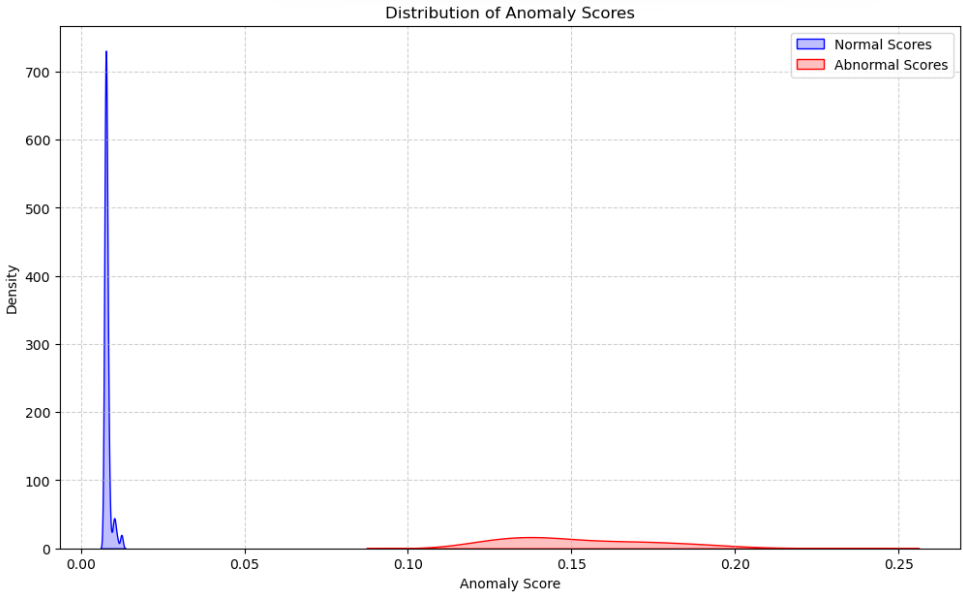

In [2]:
import torch

# 假設 model 是已訓練好的 nn.Module
PATH = "./DCdetector.pth"
torch.save(agent.model.state_dict(), PATH)